In [ ]:
from fastai.vision.all import *

In [ ]:
url = "https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z"

In [ ]:
!gdown {url}

Downloading...
From: https://drive.google.com/uc?id=18xM3jU2dSp1DiDqEM6PVXattNMZvsX4z
To: /home/jovyan/local/zach/walkwithfastai-revisited/nbs/Portrait.zip
100%|████████████████████████████████████████| 107M/107M [00:03<00:00, 34.5MB/s]


In [ ]:
from zipfile import ZipFile

with ZipFile("../Portrait.zip", "r") as zip_ref:
    zip_ref.extractall("../data")

In [ ]:
path = Path("../data")

In [ ]:
for walk in path.ls():
    print(repr(walk), walk.is_file())

Path('../data/images.csv') True
Path('../data/images_compressed') False
Path('../data/images_original') False
Path('../data/images_data_crop') False
Path('../data/train.txt') True
Path('../data/GT_png') False
Path('../data/EG1800_val.txt') True
Path('../data/val.txt') True
Path('../data/EG1800_train.txt') True


In [ ]:
(path/"GT_png").ls()[0]

Path('../data/GT_png/02218_mask.png')

In [ ]:
mask = Image.open((path/"GT_png").ls()[0])

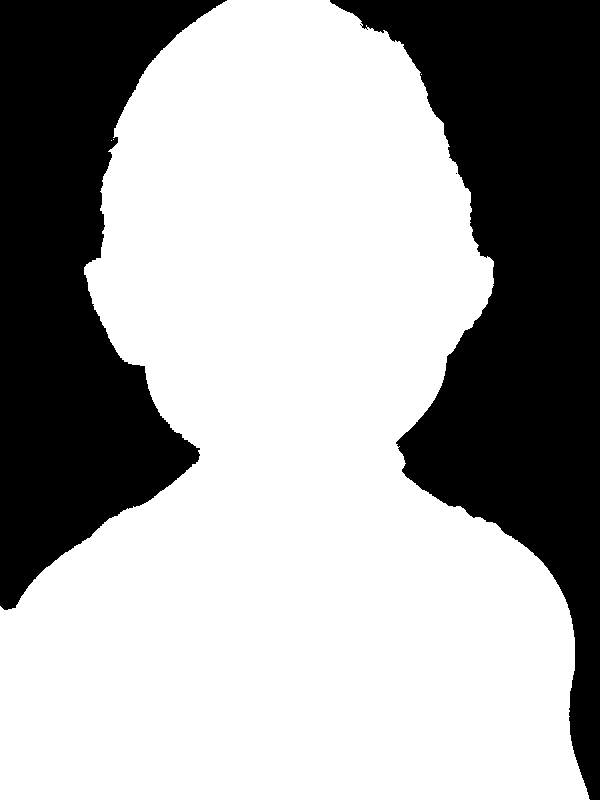

In [ ]:
mask

In [ ]:
mask = np.asarray(mask); mask

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [ ]:
def get_codes(fnames) -> Dict[int,int]: 
    "Returns a dictionary of `original_code:new_code` for pixel values in segmentation masks"
    unique_codes = set()
    for fname in fnames:
        mask = Image.open(fname)
        mask = np.asarray(mask)
        for color in np.unique(mask):
            unique_codes.add(color)
    return {
        i : color
        for i, color in 
        enumerate(unique_codes)
    }

In [ ]:
unique_codes = get_codes((path/"GT_png").ls()[:20])
unique_codes

{0: 0, 1: 255}

In [ ]:
mask = mask.copy()
np.place(mask, mask==255, 1)
np.unique(mask)

array([0, 1], dtype=uint8)

In [ ]:
codes = ["Background", "Face"]
blocks = (ImageBlock, MaskBlock(codes=codes))

In [ ]:
unique_codes

{0: 0, 1: 255}

In [ ]:
def get_y(filename:Path, unique_codes:dict):
    "Grabs a mask from `filename` and adjusts the pixel values based on `unique_codes`"
    filename = path/"GT_png"/f'{filename.stem}_mask.png'
    mask = np.asarray(Image.open(filename)).copy()
    for new_value, old_value in unique_codes.items():
        np.place(mask, mask==old_value, new_value)
    return PILMask.create(mask)

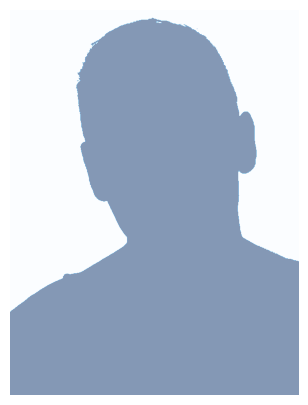

In [ ]:
new_mask = get_y((path/"images_data_crop").ls()[0], unique_codes)
new_mask.show(cmap="Blues");

In [ ]:
block = DataBlock(
    blocks=blocks,
    splitter=RandomSplitter(),
    get_y=partial(get_y, unique_codes=unique_codes),
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = block.dataloaders(
    get_image_files(path/'images_data_crop'), 
    bs=8
)

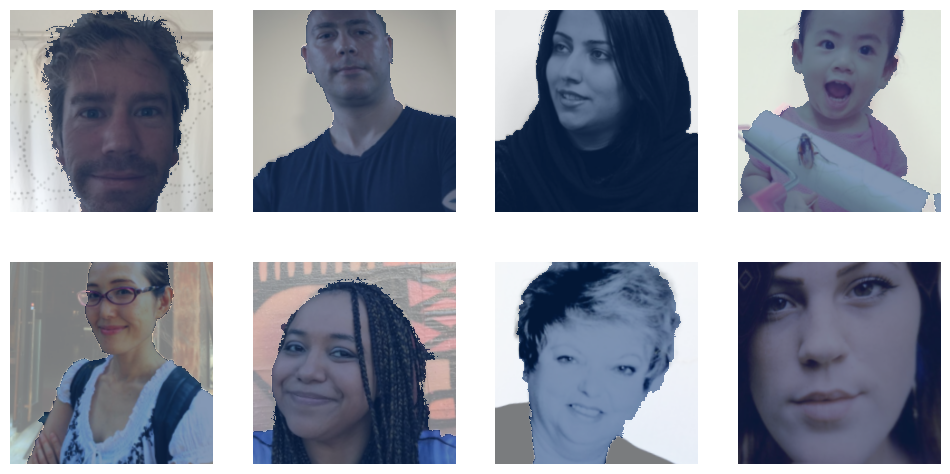

In [ ]:
dls.show_batch(cmap="Blues", vmin=0, vmax=1)

In [ ]:
splitter = RandomSplitter()
dsets = Datasets(
    get_image_files(path/'images_data_crop'),
    tfms=[
        [PILImage.create], 
        [partial(get_y, unique_codes=unique_codes)]
    ],
    splits = splitter(get_image_files(path/'images_data_crop'))
)

In [ ]:
dls = dsets.dataloaders(
    after_item = [
        Resize(224), 
        ToTensor(), 
        AddMaskCodes(codes=codes)
    ],
    after_batch = [
        *aug_transforms(), 
        IntToFloatTensor(), 
        Normalize.from_stats(*imagenet_stats)
    ],
    bs=8
)

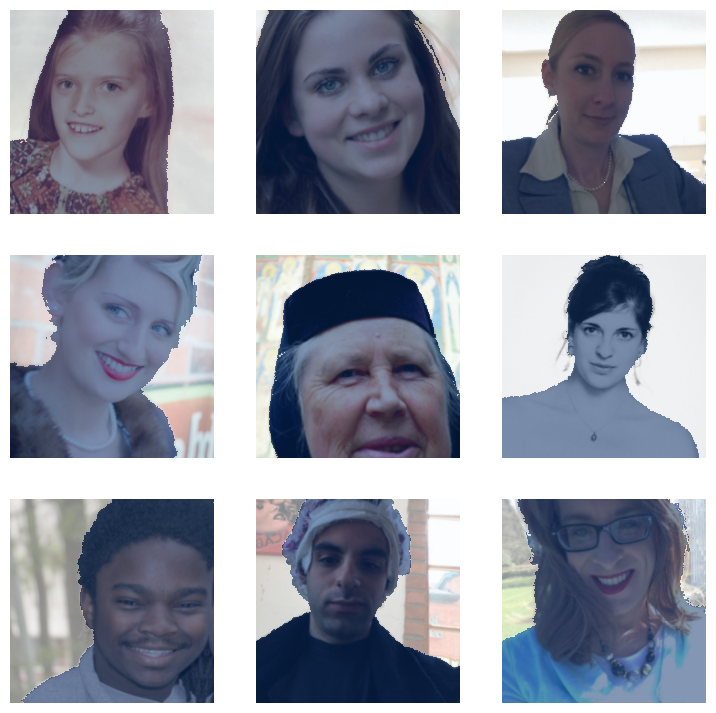

In [ ]:
dls.show_batch(cmap="Blues", vmin=0, vmax=1)

In [ ]:
learn = unet_learner(
    dls, 
    resnet34, 
    metrics=accuracy, 
    self_attention=True, 
    act_cls=Mish,
    loss_func = CrossEntropyLossFlat(axis=1)
)

In [ ]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.save("stage_1")
#learn.load("stage_1")

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(12, slice(1e-3/400, 1e-3/4)

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))

In [ ]:
dl = learn.dls.test_dl(
    (path/'images_data_crop').ls()[:5]
)
dl.show_batch()

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds.shape

In [ ]:
pred = preds[0].argmax(dim=0)

In [ ]:
preds.shape

In [ ]:
plt.imshow(pred);

In [ ]:
pred = pred.numpy()
rescaled = (255.0 / pred.max() * (pred - pred.min())).astype(np.uint8)
im = Image.fromarray(rescaled)
im.save("mask.png")

In [ ]:
im

In [ ]:
fnames = (path/'images_data_crop').ls()[:5]

item_tfms = Pipeline([
    PILImage.create, 
    RandomResizedCrop(224), 
    ToTensor()
], split_idx=1)

batch_tfms = Pipeline([
    IntToFloatTensor(), 
    Normalize.from_stats(*imagenet_stats)
])

batch = []
for fname in fnames:
    batch.append(item_tfms(fname))
batch = torch.cat(batch, dim=1)
batch = batch_tfms(batch)

model = learn.model
model.eval()

with torch.no_grad():
    preds = model(batch)

for i,pred in enumerate(preds):
    pred = pred.argmax(0)
    pred = pred.numpy()
    rescaled = (255.0 / pred.max() * (pred - pred.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(f'pred_{i}.png')